In [132]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [133]:
# Load in our libraries
import pandas as pd
import numpy as np
import re  # regular expressions
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import plotly.offline as py

py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings

warnings.filterwarnings("ignore")

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [134]:
# Load in the train and test datasets
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Store our passenger ID for easy access
PassengerId = test["PassengerId"]

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [135]:
full_data = [train, test]

train["Name_length"] = train["Name"].apply(len)
test["Name_length"] = test["Name"].apply(len)

# Feature that tells whether a passenger had a cabin on the Titanic
train["Has_Cabin"] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test["Has_Cabin"] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1

# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset["IsAlone"] = 0
    dataset.loc[dataset["FamilySize"] == 1, "IsAlone"] = 1

# Remove all NULLS in the Embarked column
# embarked feature has some missing value. and we fill those with the most occurred value ( 'S' ).
for dataset in full_data:
    dataset["Embarked"] = dataset["Embarked"].fillna("S")

# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset["Fare"] = dataset["Fare"].fillna(train["Fare"].median())
    # == dataset.Fare.fillna(dataset.Fare.median(), inplace=True)

train["CategoricalFare"] = pd.qcut(train["Fare"], 4)

# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset["Age"].mean()
    age_std = dataset["Age"].std()
    age_null_count = dataset["Age"].isnull().sum()
    age_null_random_list = np.random.randint(
        age_avg - age_std, age_avg + age_std, size=age_null_count
    )
    dataset["Age"][np.isnan(dataset["Age"])] = age_null_random_list
    dataset["Age"] = dataset["Age"].astype(int)
train["CategoricalAge"] = pd.cut(train["Age"], 5)


# Extract titles from passenger names
def get_title(name):
    title_search = re.search(" ([A-Za-z]+)\.", name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""


# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset["Title"] = dataset["Name"].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset["Title"] = dataset["Title"].replace(
        [
            "Lady",
            "Countess",
            "Capt",
            "Col",
            "Don",
            "Dr",
            "Major",
            "Rev",
            "Sir",
            "Jonkheer",
            "Dona",
        ],
        "Rare",
    )

    dataset["Title"] = dataset["Title"].replace("Mlle", "Miss")
    dataset["Title"] = dataset["Title"].replace("Ms", "Miss")
    dataset["Title"] = dataset["Title"].replace("Mme", "Mrs")

for dataset in full_data:
    # Mapping Sex
    dataset["Sex"] = dataset["Sex"].map({"female": 0, "male": 1}).astype(int)

    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset["Title"] = dataset["Title"].map(title_mapping)
    # dataset["Title"] = dataset["Title"].fillna(0)  # this is unnecessary for both train and test

    # Mapping Embarked
    dataset["Embarked"] = dataset["Embarked"].map({"S": 0, "C": 1, "Q": 2})

    # Mapping Fare
    dataset.loc[dataset["Fare"] <= 7.91, "Fare"] = 0
    dataset.loc[(dataset["Fare"] > 7.91) & (dataset["Fare"] <= 14.454), "Fare"] = 1
    dataset.loc[(dataset["Fare"] > 14.454) & (dataset["Fare"] <= 31), "Fare"] = 2
    dataset.loc[dataset["Fare"] > 31, "Fare"] = 3
    # dataset["Fare"] = dataset["Fare"].astype(int) --> they are already int

    # train["CategoricalFare2"] = pd.qcut(train["Fare"], 4, labels=[0, 1, 2, 3])
    # test["CategoricalFare2"] = pd.qcut(test["Fare"], 4, labels=[0, 1, 2, 3])
    # You can't do this because train and test have different ranges of Fare

    # Mapping Age
    dataset.loc[dataset["Age"] <= 16, "Age"] = 0
    dataset.loc[(dataset["Age"] > 16) & (dataset["Age"] <= 32), "Age"] = 1
    dataset.loc[(dataset["Age"] > 32) & (dataset["Age"] <= 48), "Age"] = 2
    dataset.loc[(dataset["Age"] > 48) & (dataset["Age"] <= 64), "Age"] = 3
    dataset.loc[dataset["Age"] > 64, "Age"] = 4
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0.0,NaN,0,23,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3.0,C85,1,51,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1.0,NaN,0,22,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3.0,C123,0,44,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1.0,NaN,0,24,0,1,1,"(7.91, 14.454]","(32.0, 48.0]",1


feature selection

In [136]:
drop_elements = ["PassengerId", "Name", "Ticket", "Cabin", "SibSp"]
train = train.drop(drop_elements, axis=1)
train = train.drop(["CategoricalAge", "CategoricalFare"], axis=1)
test = test.drop(drop_elements, axis=1)

In [137]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0.0,0,23,0,2,0,1
1,1,1,0,2,0,3.0,1,51,1,2,0,3
2,1,3,0,1,0,1.0,0,22,0,1,1,2
3,1,1,0,2,0,3.0,0,44,1,2,0,3
4,0,3,1,2,0,1.0,0,24,0,1,1,1


Pearson Correlation Heatmap

there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information.

<Axes: title={'center': 'Pearson Correlation of Features'}>

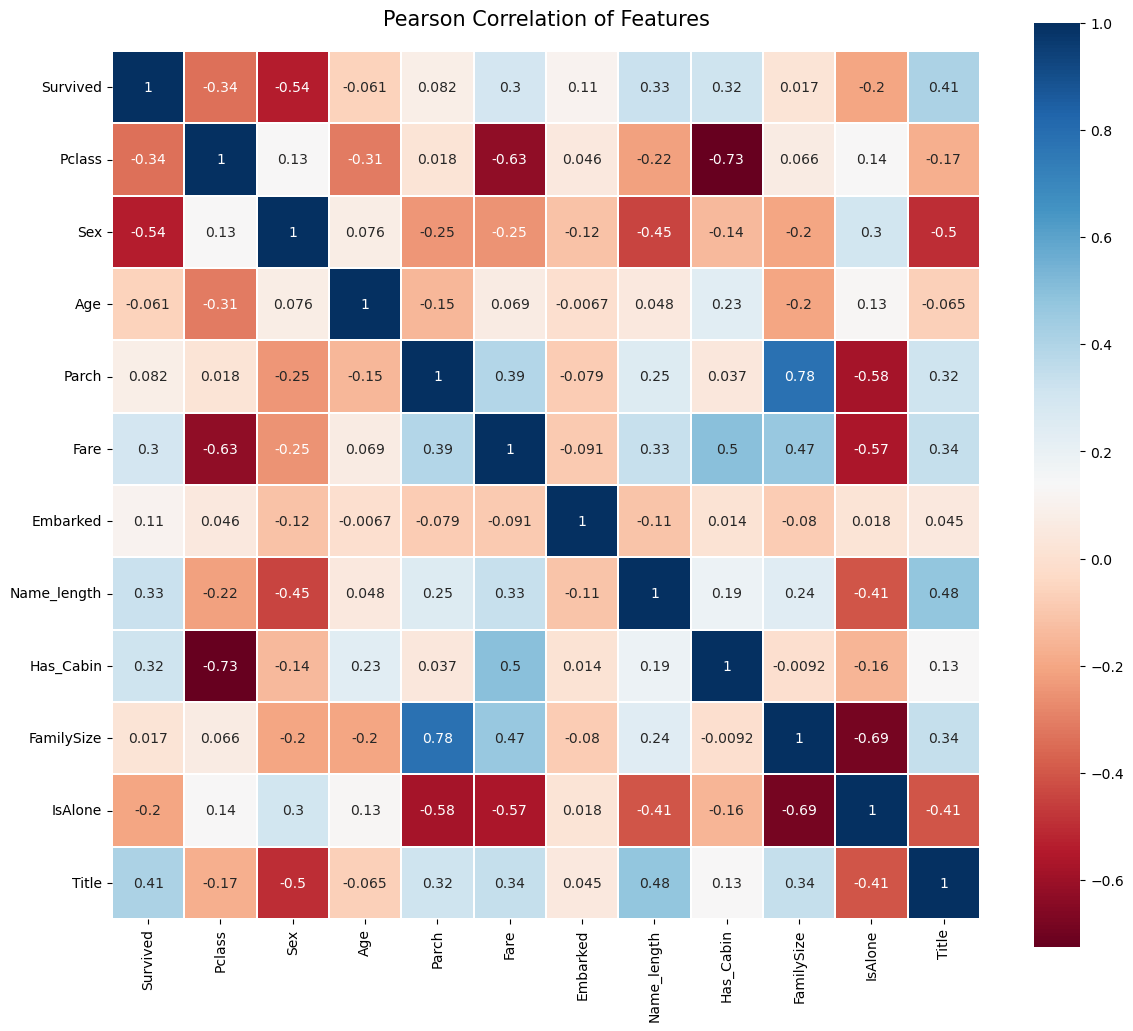

In [138]:
plt.figure(figsize=(14, 12))
plt.title("Pearson Correlation of Features", y=1.02, size=15)
sns.heatmap(
    train.astype(float).corr(),
    linewidths=0.1,
    vmax=1.0,
    square=True,
    cmap=plt.cm.RdBu,
    linecolor="white",
    annot=True,
)

Pairplots

let us generate some pairplots to observe the distribution of data from one feature to the other.

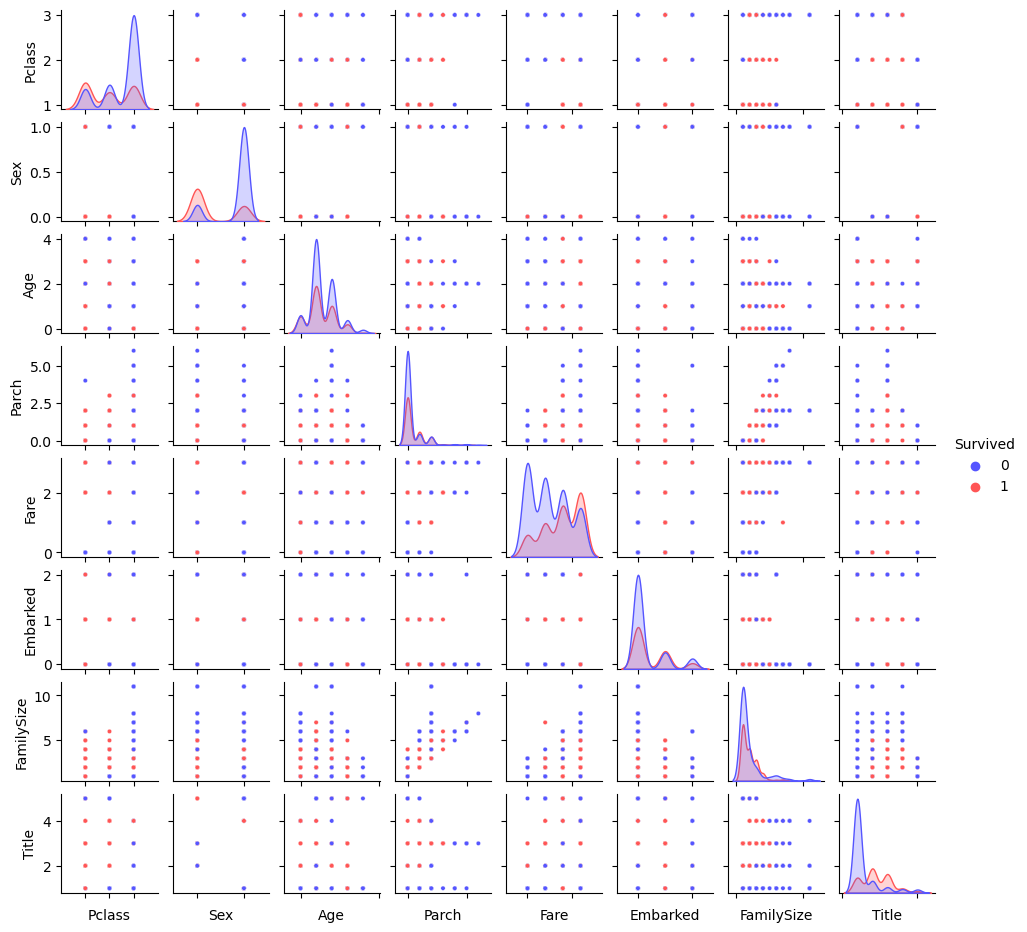

In [139]:
g = sns.pairplot(
    train[
        [
            "Survived",
            "Pclass",
            "Sex",
            "Age",
            "Parch",
            "Fare",
            "Embarked",
            "FamilySize",
            "Title",
        ]
    ],
    hue="Survived",
    palette="seismic",
    size=1.2,
    diag_kind="kde",
    diag_kws=dict(shade=True),
    plot_kws=dict(s=10),
)
g.set(xticklabels=[])

In [140]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0  # for reproducibility
NFOLDS = 5  # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS)


class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params["random_state"] = seed
        self.model = clf(**params)

    def train(self, x_train, y_train):
        self.model.fit(x_train, y_train)

    def predict(self, x):
        return self.model.predict(x)

    def fit(self, x, y):
        return self.model.fit(x, y)

In [141]:
def get_oof(clf, x_train, y_train, x_test):
    train = np.zeros((ntrain,))
    test = np.zeros((ntest,))
    test_folds = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        clf.train(x_train[train_index], y_train[train_index])

        train[test_index] = clf.predict(x_train[test_index])

        test_folds[i, :] = clf.predict(x_test)

    test[:] = test_folds.mean(axis=0)
    
    return train.reshape(-1, 1), test.reshape(-1, 1)

In [142]:
# 'fit' Resets a Model
# Calling fit always resets everything a model previously learned.(p.119)
# if warm_start=True, then calling fit will continue training where it left off
# random forest parameters
rf_params = {
    "n_jobs": -1,
    "n_estimators": 500,
    "warm_start": True,
    "max_depth": 6,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
}

# Extra Trees Parameters
et_params = {
    "max_depth": 8,
    "min_samples_leaf": 2,
}

# AdaBoost parameters
ada_params = {"n_estimators": 500, "learning_rate": 0.75}

# Gradient Boosting parameters
gb_params = {
    "n_estimators": 500,
    "max_depth": 5,
    "min_samples_leaf": 2,
}

# Support Vector Classifier parameters
svc_params = {"kernel": "linear", "C": 0.025}

In [143]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [144]:
y_train = train["Survived"].ravel()
train = train.drop(["Survived"], axis=1)
x_train = train.values  # Return a Numpy representation of the DataFrame
x_test = test.values

In [145]:
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)  # Random Forest
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)  # Extra Trees
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)  # AdaBoost
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)  # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)  # Support Vector

In [146]:
def plot_feature_importances(model):
    print(model.model.feature_importances_)
    n_features = train.shape[1]
    plt.barh(range(n_features), model.model.feature_importances_, align="center")
    plt.yticks(np.arange(n_features), train.columns.values)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

    return model.model.feature_importances_

[0.12473214 0.19618296 0.02987726 0.02148648 0.07236432 0.02433653
 0.10999668 0.06542505 0.06697584 0.01321899 0.27540375]


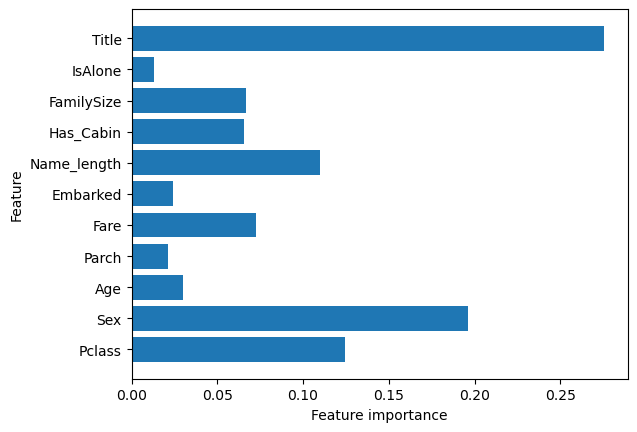

In [147]:
df_feature_importances = pd.DataFrame(index=train.columns.values)

df_feature_importances["rf"] = plot_feature_importances(rf)

[0.12079687 0.3799164  0.02796359 0.01794187 0.05209604 0.03240723
 0.0607512  0.07791605 0.03942718 0.01928136 0.17150221]


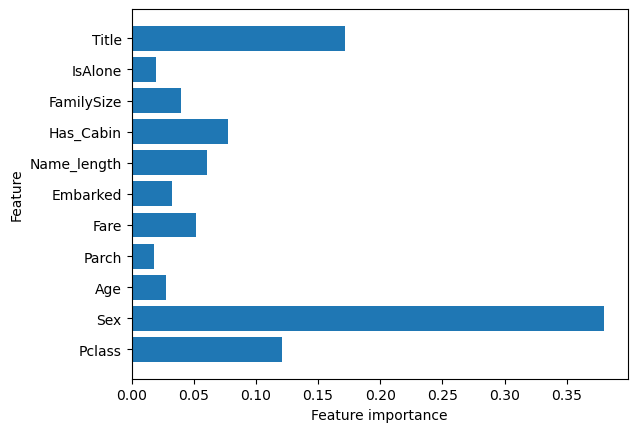

In [148]:
df_feature_importances["et"] = plot_feature_importances(et)

[0.022 0.002 0.018 0.074 0.038 0.012 0.68  0.004 0.072 0.002 0.076]


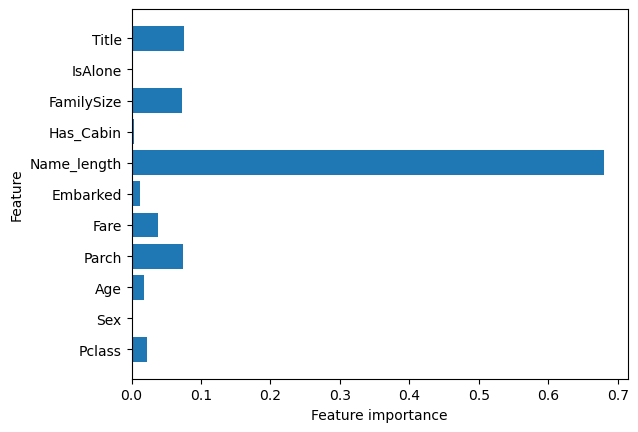

In [149]:
df_feature_importances["ada"] = plot_feature_importances(ada)

[0.11603103 0.00545394 0.05075003 0.013445   0.0477284  0.02682088
 0.20427969 0.03100335 0.08637517 0.00882141 0.4092911 ]


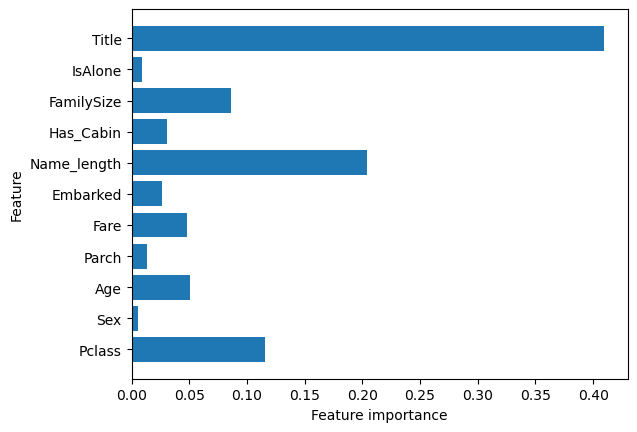

In [150]:
df_feature_importances["gb"] = plot_feature_importances(gb)

,rf,et,ada,gb,mean
Pclass,0.124732,0.120797,0.022,0.116031,0.095890
Sex,0.196183,0.379916,0.002,0.005454,0.145888
Age,0.029877,0.027964,0.018,0.050750,0.031648
Parch,0.021486,0.017942,0.074,0.013445,0.031718
Fare,0.072364,0.052096,0.038,0.047728,0.052547
Embarked,0.024337,0.032407,0.012,0.026821,0.023891
Name_length,0.109997,0.060751,0.680,0.204280,0.263757
Has_Cabin,0.065425,0.077916,0.004,0.031003,0.044586
FamilySize,0.066976,0.039427,0.072,0.086375,0.066195
IsAlone,0.013219,0.019281,0.002,0.008821,0.010830


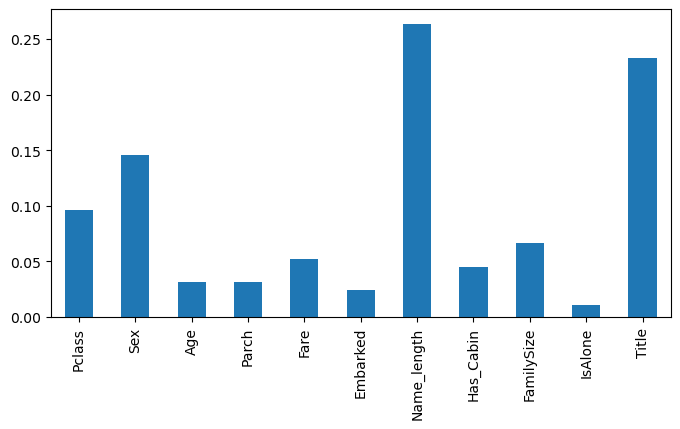

In [151]:
df_feature_importances["mean"] = df_feature_importances.mean(axis=1)
df_feature_importances.mean(axis=1).plot(kind="bar", figsize=(8, 4))
df_feature_importances

In [153]:
base_predictions_train = pd.DataFrame(
    {
        "RandomForest": rf_oof_train.ravel(),
        "ExtraTrees": et_oof_train.ravel(),
        "AdaBoost": ada_oof_train.ravel(),
        "GradientBoost": gb_oof_train.ravel(),
    }
)
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


<Axes: >

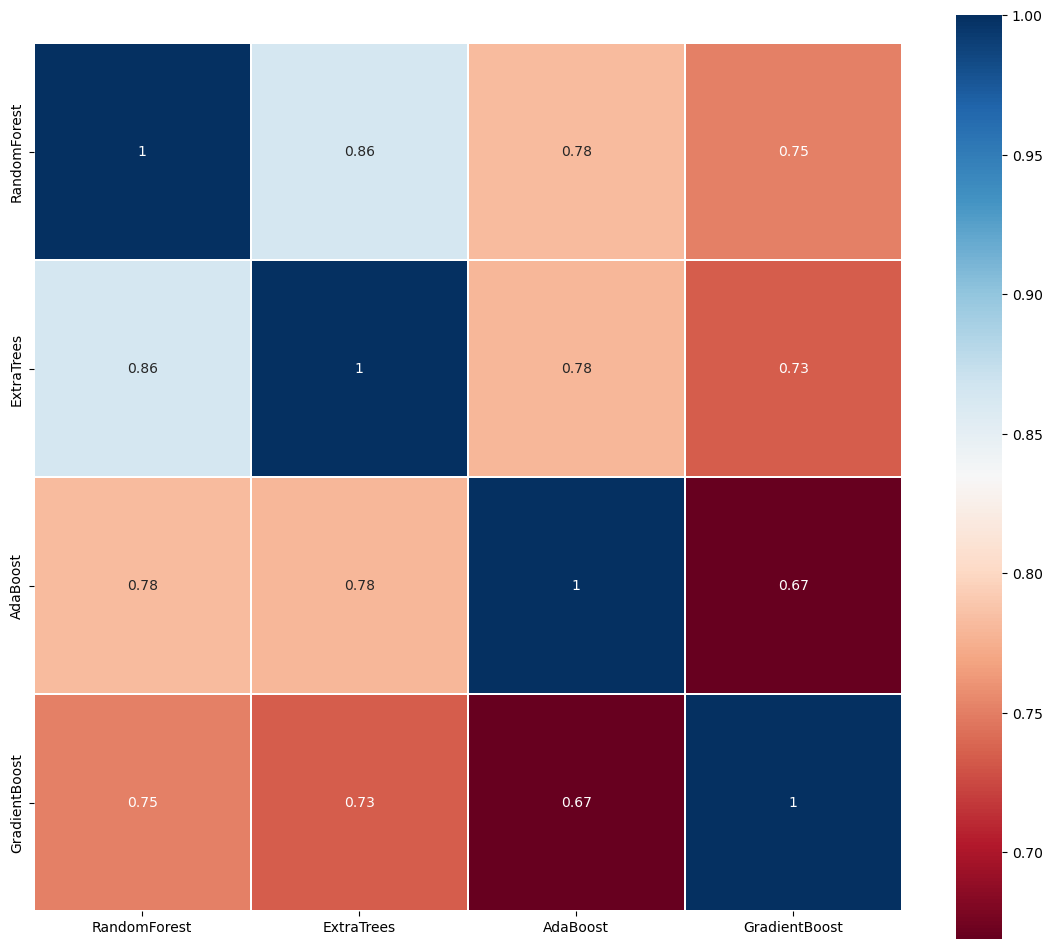

In [161]:
plt.figure(figsize=(14, 12))
sns.heatmap(
    base_predictions_train.astype(float).corr(),
    linewidths=0.1,
    vmax=1.0,
    square=True,
    cmap=plt.cm.RdBu,
    linecolor="white",
    annot=True,
)

In [163]:
x_train = np.concatenate(
    (et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1
)
x_test = np.concatenate(
    (et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1
)
x_train

array([[0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])